<a href="https://colab.research.google.com/github/gongx030/etv2_pioneer/blob/master/Etv2_binding_D1_MEF_extended.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examine the nucleosome profiles at Etv2 binding sites at D1 MEF on Etv2 induction
by Wuming Gong



This notebook examines the MEF MNase-seq signal at the Etv2 binding sites at MEF D1 post Etv2 induction.  The anaysis shows that Etv2 binds both NFR and NOR regions

In [1]:
start_time0 <- Sys.time()
options(max.print=1000)

### Install external packages

In [2]:
system('apt-get -q install libgsl-dev', intern = TRUE)

[1] "Reading package lists..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
 [2] "Building dependency tree..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
 [3] "Reading state information..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
 [4] "The following additional packages will be installed:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
 [5] "  libgsl23 libgslcblas0"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
 [6] "Suggested packages:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
 [7] "  gsl-ref-psdoc | gsl-doc-pdf | gsl-doc-info | gsl-ref-html"                                                           

In [3]:
system('apt-get install libcairo2-dev', intern = TRUE) # for Cairo package that is required by ComplexHeatmap package

[1] "Reading package lists..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
 [2] "Building dependency tree..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
 [3] "Reading state information..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
 [4] "The following additional packages will be installed:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
 [5] "  libcairo-script-interpreter2 libpixman-1-dev libxcb-shm0-dev"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
 [6] "Suggested packages:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
 [7] "  libcairo2-doc"                                                                                                       

## Install R packages

In [4]:
install.packages('BiocManager')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
required_packages <- c(
  'devtools',
  'GenomicRanges', 'rtracklayer', 
  'BSgenome.Mmusculus.UCSC.mm10',
  'EnrichedHeatmap',  'circlize'
)

In [6]:
missing_packages <- required_packages[!required_packages %in% rownames(installed.packages())]
if (length(missing_packages) > 0){
    BiocManager::install(missing_packages)
}

Bioconductor version 3.12 (BiocManager 1.30.10), R 4.0.3 (2020-10-10)

Installing package(s) 'BiocVersion', 'GenomicRanges', 'rtracklayer',
  'BSgenome.Mmusculus.UCSC.mm10', 'EnrichedHeatmap', 'circlize'

also installing the dependencies ‘formatR’, ‘lambda.r’, ‘futile.options’, ‘futile.logger’, ‘snow’, ‘MatrixGenerics’, ‘Biobase’, ‘DelayedArray’, ‘GenomeInfoDbData’, ‘bitops’, ‘BiocParallel’, ‘Rhtslib’, ‘SummarizedExperiment’, ‘clue’, ‘png’, ‘Cairo’, ‘rjson’, ‘BiocGenerics’, ‘S4Vectors’, ‘IRanges’, ‘GenomeInfoDb’, ‘XVector’, ‘XML’, ‘Biostrings’, ‘zlibbioc’, ‘RCurl’, ‘Rsamtools’, ‘GenomicAlignments’, ‘BSgenome’, ‘ComplexHeatmap’, ‘matrixStats’, ‘GetoptLong’, ‘locfit’, ‘GlobalOptions’, ‘shape’


Old packages: 'cachem', 'dbplyr', 'nlme'



In [7]:
library(devtools)

Loading required package: usethis



## Load R packages

In [8]:
library(GenomicRanges)
library(dplyr)
library(BSgenome.Mmusculus.UCSC.mm10)
library(SummarizedExperiment)
library(ggplot2)
library(EnrichedHeatmap)
library(circlize) # colorRamp2

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The follow

## Read the Etv2 ChIP-seq peaks at D1 MEF reprogramming

In [10]:
all_etv2_peaks_url <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/all_Etv2_peaks.rds'
gr <- readRDS(gzcon(url(all_etv2_peaks_url)))
gr
colnames(gr$group)

GRanges object with 162010 ranges and 4 metadata columns:
           seqnames            ranges strand |                peak_id     score
              <Rle>         <IRanges>  <Rle> |            <character> <numeric>
       [1]     chr1   3037784-3037983      * | /panfs/roc/scratch/g..  16.22768
       [2]     chr1   3263790-3263989      * | /panfs/roc/scratch/g..   8.36521
       [3]     chr1   3344682-3344881      * | /panfs/roc/scratch/g..   9.73217
       [4]     chr1   3460640-3460839      * | /panfs/roc/scratch/g..   3.92081
       [5]     chr1   3490314-3490513      * | /panfs/roc/scratch/g..  12.29730
       ...      ...               ...    ... .                    ...       ...
  [162006]     chrY 90828936-90829135      * | /panfs/roc/scratch/g.. 160.15463
  [162007]     chrY 90836259-90836458      * | /panfs/roc/scratch/g..   8.27339
  [162008]     chrY 90841624-90841823      * | /panfs/roc/scratch/g..   1.53792
  [162009]     chrY 90842563-90842762      * | /panfs/roc/scra

[1] "MEF_Dox_d1_Etv2" "MEF_Dox_d2_Etv2" "MEF_Dox_d7_Etv2" "EB_Dox_3h_Etv2" 
[5] "EB_Dox_12h_Etv2"

In [11]:
peaks <- gr[gr$group[, 'MEF_Dox_d1_Etv2']]
seqlevels(peaks) <- seqlevels(BSgenome.Mmusculus.UCSC.mm10)
seqlengths(peaks) <- seqlengths(BSgenome.Mmusculus.UCSC.mm10)
seqinfo(peaks) <- seqinfo(BSgenome.Mmusculus.UCSC.mm10)
peaks

GRanges object with 123337 ranges and 4 metadata columns:
           seqnames            ranges strand |                peak_id     score
              <Rle>         <IRanges>  <Rle> |            <character> <numeric>
       [1]     chr1   3037784-3037983      * | /panfs/roc/scratch/g..  16.22768
       [2]     chr1   3490314-3490513      * | /panfs/roc/scratch/g..  12.29730
       [3]     chr1   3531626-3531825      * | /panfs/roc/scratch/g..  16.22768
       [4]     chr1   3671125-3671324      * | /panfs/roc/scratch/g..   6.73792
       [5]     chr1   3671746-3671945      * | /panfs/roc/scratch/g..   9.54304
       ...      ...               ...    ... .                    ...       ...
  [123333]     chrY 90828479-90828678      * | /panfs/roc/scratch/g..  20.49355
  [123334]     chrY 90828936-90829135      * | /panfs/roc/scratch/g.. 160.15463
  [123335]     chrY 90841624-90841823      * | /panfs/roc/scratch/g..   1.53792
  [123336]     chrY 90842563-90842762      * | /panfs/roc/scra

## Download related `pileup` and `fold enrichment` bigwig files

`rtracklayer::import` does not support importing bigwig files with URL starting with 'https://'. We need to download the bigwig files first.

In [12]:
bw_files <- c(
	'MEF_Dox_D1_Etv2' 									= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_Etv2_FE.bw',
#	'MEF_Dox_D2_Etv2' 									= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d2_Etv2_FE.bw',
#	'MEF_Dox_D7_Etv2' 									= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_Etv2_FE.bw',
	'MEF_NoDox_Brg1' 										= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_NoDox_d0_Brg1_FE.bw',
#	'MEF_Dox_D1_Brg1' 									= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_Brg1_FE.bw',
#	'MEF_Dox_D2_Brg1' 									= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d2_Brg1_FE.bw',
#	'MEF_Dox_D7_Brg1' 									= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_Brg1_FE.bw',
  'MEF_NoDox_H3K27ac' 								= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_NoDox_d0_H3K27ac_FE.bw',
#  'MEF_Dox_D1_H3K27ac' 								= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d1_H3K27ac_FE.bw',
#  'MEF_Dox_D2_H3K27ac' 								= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d2_H3K27ac_FE.bw',
#  'MEF_Dox_D7_H3K27ac' 								= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/MEF_Dox_d7_H3K27ac_FE.bw'
	'MNase'                             = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/MNase_treat_pileup.bw',
	'H3'                                = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3_treat_pileup.bw',
	'H3K9me3'                           = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3K9me3_treat_pileup.bw',
	'H3K27me3'                          = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3K27me3_treat_pileup.bw',
#	'H3K36me3'                          = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3K36me3_treat_pileup.bw',
	'H3K9ac'                            = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3K9ac_treat_pileup.bw',
#	'H3K79me2'                          = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3K79me2_treat_pileup.bw',
	'H3K4me2'                           = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3K4me2_treat_pileup.bw',
	'H3K4me1'                           = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3K4me1_treat_pileup.bw',
	'Hdac1'                             = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/Hdac1_treat_pileup.bw'
#	'H3.3'                              = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/H3.3_treat_pileup.bw',
#	'P300'                              = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Chronis_version=20170519a/P300_treat_pileup.bw',
#	'EB_Dox_3h_Etv2' 					= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_Dox_3h_Etv2_FE.bw',
#	'EB_Dox_12h_Etv2' 					= 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_Dox_12h_Etv2_FE.bw',
#	'EB_Dox_3h_Brg1' =  'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_Dox_3h_Brg1_FE.bw',
#	'EB_Dox_12h_Brg1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_Dox_12h_Brg1_FE.bw',
#	'EB_NoDox_3h_Brg1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_NoDox_3h_Brg1_FE.bw',
#	'EB_NoDox_12h_Brg1' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_NoDox_12h_Brg1_FE.bw',
#	'EB_Dox_3h_H3K27ac' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_Dox_3h_H3K27ac_FE.bw',
#	'EB_Dox_12h_H3K27ac' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_Dox_12h_H3K27ac_FE.bw',
#	'EB_NoDox_3h_H3K27ac' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_NoDox_3h_H3K27ac_FE.bw',
#	'EB_NoDox_12h_H3K27ac' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Etv2PioneerChIPseq_version=20191203a/EB_NoDox_12h_H3K27ac_FE.bw'
)

In [13]:
for (i in 1:length(bw_files)){
  sprintf('wget -x -c -nH %s', bw_files[i]) %>% system()
}
local_bw_files <- gsub('https://s3.msi.umn.edu/', './', bw_files)

In [14]:
message(sprintf('all local_bw_files exist: %s', all(file.exists(local_bw_files))))

all local_bw_files exist: TRUE



## Prepare normalized matrix for `EnrichedHeatmap`

In [15]:
sprintf('number of Etv2 peaks in MEFS: %d', length(peaks)) %>% message()

number of Etv2 peaks in MEFS: 123337



In [16]:
extend <- 1000
w <- 50
smooth <- FALSE
target_ratio <- 0.2
target_width <- width(peaks)[1]
message(sprintf('target width: %d\n', target_width))

target width: 200




In [17]:
mat <- lapply(local_bw_files, function(bw_file){
  cvg <- rtracklayer::import(
    bw_file, 
    which = trim(GenomicRanges::reduce(resize(peaks, fix = 'center', width = target_width + extend * 2)))
  )  # returned as a GRanges object
  normalizeToMatrix(
    cvg, 
    resize(peaks, fix = 'center', width = 1), 
    extend = extend, 
    value_column = 'score', 
    mean_mode = 'w0', 
    w = w, 
    smooth = smooth, 
    target_ratio = target_ratio
  )
})

Warning message in .normarg_seqnames2(seqnames, seqinfo):
“levels in 'seqnames' with no entries in 'seqinfo' were dropped”
Warning message in .normarg_seqnames2(seqnames, seqinfo):
“levels in 'seqnames' with no entries in 'seqinfo' were dropped”
Warning message in .normarg_seqnames2(seqnames, seqinfo):
“levels in 'seqnames' with no entries in 'seqinfo' were dropped”
Warning message in .normarg_seqnames2(seqnames, seqinfo):
“levels in 'seqnames' with no entries in 'seqinfo' were dropped”
Warning message in .normarg_seqnames2(seqnames, seqinfo):
“levels in 'seqnames' with no entries in 'seqinfo' were dropped”
Warning message in .normarg_seqnames2(seqnames, seqinfo):
“levels in 'seqnames' with no entries in 'seqinfo' were dropped”
Warning message in .normarg_seqnames2(seqnames, seqinfo):
“levels in 'seqnames' with no entries in 'seqinfo' were dropped”
Warning message in .normarg_seqnames2(seqnames, seqinfo):
“levels in 'seqnames' with no entries in 'seqinfo' were dropped”
Warning message 

### Color scheme of the heatmap

In [18]:
group_cols <- rep('brown', length(bw_files))
names(group_cols) <- names(bw_files)
group_cols[c('MNase', 'H3')] <- 'navyblue'
group_cols[c('MEF_Dox_D1_Etv2')] <- 'red'
group_cols[c('MEF_NoDox_Brg1')] <- 'purple'
group_cols[c('MEF_NoDox_H3K27ac')] <- 'darkgreen'
group_cols[c('H3K9me3', 'H3K27me3', 'H3K9ac', 'H3K4me2', 'H3K4me1', 'Hdac1')] <- 'blue'
col_fun <- lapply(1:length(mat), function(i) colorRamp2(quantile(mat[[i]], c(0.005, 0.995)), c('white', group_cols[i])))
names(col_fun) <- names(bw_files)

### Generate the heatmap

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FA

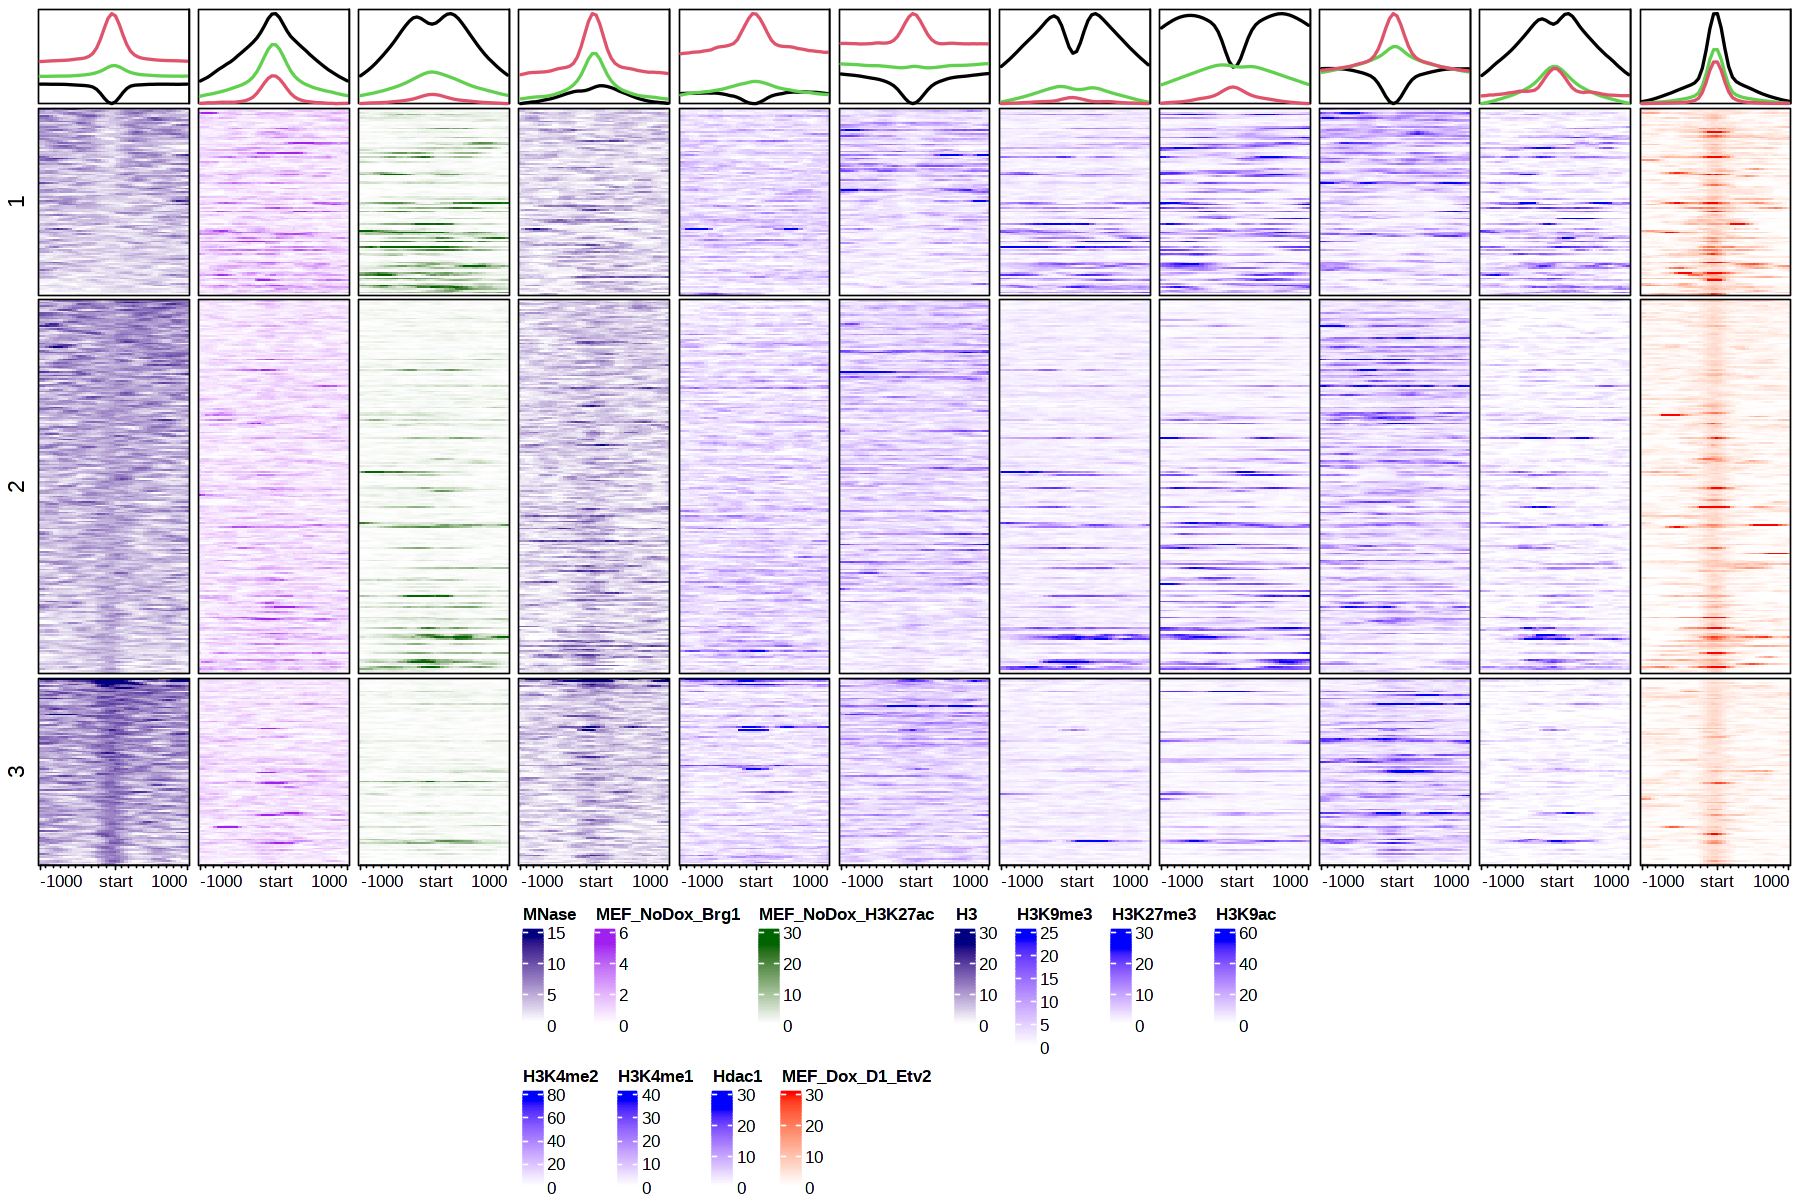

In [21]:
i <- seq_len(length(peaks))
mean_mnase <- rowMeans(mat[['MNase']][, (extend / w - 1):(extend / w  + 1)])
cls <- as.numeric(cut(mean_mnase, quantile(mean_mnase, c(1, 0.75, 0.25, 0)), include.lowest = TRUE))
sp <- factor(cls)
ta <- HeatmapAnnotation(enriched = anno_enriched(gp = gpar(lty = 1, lwd = 2, col = c(1, 3, 2)), axis_param = list(facing = 'inside', at = -1000)))
h <- EnrichedHeatmap(mat[['MNase']][i, ], col = col_fun[['MNase']], split = sp[i], name = 'MNase', top_annotation = ta, pos_line = FALSE)
ss <- c('MEF_NoDox_Brg1', 'MEF_NoDox_H3K27ac', 'H3', 'H3K9me3', 'H3K27me3', 'H3K9ac', 'H3K4me2', 'H3K4me1', 'Hdac1', 'MEF_Dox_D1_Etv2')
for (s in ss[ss %in% names(bw_files)]){
  h <- h + EnrichedHeatmap(mat[[s]][i, ], col = col_fun[[s]], name = s, top_annotation = ta, pos_line = FALSE)
}

options(repr.plot.width = 15, repr.plot.height = 10)
draw(h, heatmap_legend_side = 'bottom')

In [22]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] circlize_0.4.12                    EnrichedHeatmap_1.20.0            
 [3] ComplexHeatmap_2.6.2               ggplot2_3.3.3                     
 [5] SummarizedExperiment_1.20.0        Biobase_2.50.0                    
 [7] Matr

In [23]:
Sys.time() - start_time0

Time difference of 1.886268 hours